전설의 포켓몬 분류 모델
===

목차 및 개요
===
## 1. 데이터 전처리
- 경로 수정 후, 원본 손상을 피하고자 copy
- 일반 포켓몬과 전설 포켓몬을 분류 셋을 생성
- 결측치 및 컬럼 확인

## 2. 데이터 특성 확인
- 타입별 포켓몬 빈도 수 시각화하여 일반 vs 전설의 차이 구분
- total과 stats의 의미를 파악하고 시각화하여 일반 vs 전설의 차이 구분
- 이름 레이블 데이터를 활용하여, long_name(bool), name_count(int) 등의 숫자형 파생변수 생성
- 정규식을 활용한 이름 tokenize, 이름 및 type의 원핫 인코딩
- stats로만 구성된 train set만들기(baseline)

## 3. 머신러닝 모델 만들기
- accuracy, recall 등의 수치 확인 후 평가 지표 선택
- recall 수치 개선

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print('슝=3')

슝=3


## 데이터 전처리
---

* __처음부터 경로가 맞지 않아, 아래와 같이 경로 수정을 직접하였다.__

In [238]:
import os

csv_path = os.getenv("HOME") +"/data/Pokemon.csv"
original_data = pd.read_csv(csv_path)
print('슝=3')

슝=3


* __원본 손상을 피하기 위해 pokemon에 담는다__.

In [162]:
pokemon = original_data.copy()
print(pokemon.shape)
pokemon.head()

(800, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


* __레전드 포켓몬 데이터셋을 분류한다.__

In [163]:
# 전설의 포켓몬 데이터셋
legendary = pokemon[pokemon["Legendary"] == True].reset_index(drop=True)
print(legendary.shape)
legendary.head()

(65, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True


* __일반 포켓몬 데이터셋을 분류한다.__

In [164]:
# Q. 일반 포켓몬의 데이터셋도 만들어봅시다.
ordinary = pokemon[pokemon["Legendary"]==False].reset_index(drop=True)
print(ordinary.shape)
ordinary.head()

(735, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


* __결측치를 확인한다.__

In [165]:
pokemon.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

* __컬럼들을 확인한다.__

In [166]:
print(len(pokemon.columns))
pokemon.columns

13


Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

* __컬럼별 설명__
---
# # : 포켓몬 Id number. 성별이 다르지만 같은 포켓몬인 경우 등은 같은 #값을 가진다. *__int__*
* Name : 포켓몬 이름. 포켓몬 각각의 이름으로 저장되고, 800개의 포켓몬의 이름 데이터는 모두 다르다. (unique) *__str__*
* Type 1 : 첫 번째 속성. 속성을 하나만 가지는 경우 Type 1에 입력된다. *__str__*
* Type 2 : 두 번째 속성. 속성을 하나만 가지는 포켓몬의 경우 Type 2는 NaN(결측값)을 가진다. *__str__*
* Total : 전체 6가지 스탯의 총합. *__int__*
* HP : 포켓몬의 체력. *__int__*
* Attack : 물리 공격력. (scratch, punch 등) *__int__*
* Defense : 물리 공격에 대한 방어력. *__int__*
* Sp. Atk : 특수 공격력. (fire blast, bubble beam 등) *__int__*
* Sp. Def : 특수 공격에 대한 방어력. *__int__*
* Speed : 포켓몬 매치에 대해 어떤 포켓몬이 먼저 공격할지를 결정. (더 높은 포켓몬이 먼저 공격한다) *__int__*
* Generation : 포켓몬의 세대. 현재 데이터에는 6세대까지 있다. *__int__*
* Legendary : 전설의 포켓몬 여부. !! Target feature !! *__bool__*
---

## 데이터 특성 확인
---
* __컬럼의 중복되지 않는 값 조회__

In [167]:
len(set(pokemon["#"]))

721

* __#의 수가 6인 것을 조회__

In [168]:
pokemon[pokemon["#"] == 6]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


In [169]:
len(set(pokemon["Name"]))

800

In [170]:
pokemon.loc[[6, 10]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
10,8,Wartortle,Water,NaN,405,59,63,80,65,80,58,1,False


* __특성 갯수 정리__

In [171]:
len(list(set(pokemon["Type 1"]))), len(list(set(pokemon["Type 2"])))

(18, 19)

* __차집합__

In [172]:
set(pokemon["Type 2"]) - set(pokemon["Type 1"])

{nan}

In [173]:
types = list(set(pokemon["Type 1"]))
print(len(types))
print(types)

18
['Normal', 'Psychic', 'Ice', 'Water', 'Ground', 'Dragon', 'Dark', 'Poison', 'Fighting', 'Ghost', 'Flying', 'Grass', 'Fairy', 'Steel', 'Electric', 'Rock', 'Bug', 'Fire']


In [174]:
pokemon["Type 2"].isna().sum()

386

* __일반 포켓몬과 전설 포켓몬의 타입별 포켓몬 수 시각화__
    * 211~212 뜻은 두 줄 한 열의 위치에서 첫 번째, 두 번째라는 뜻

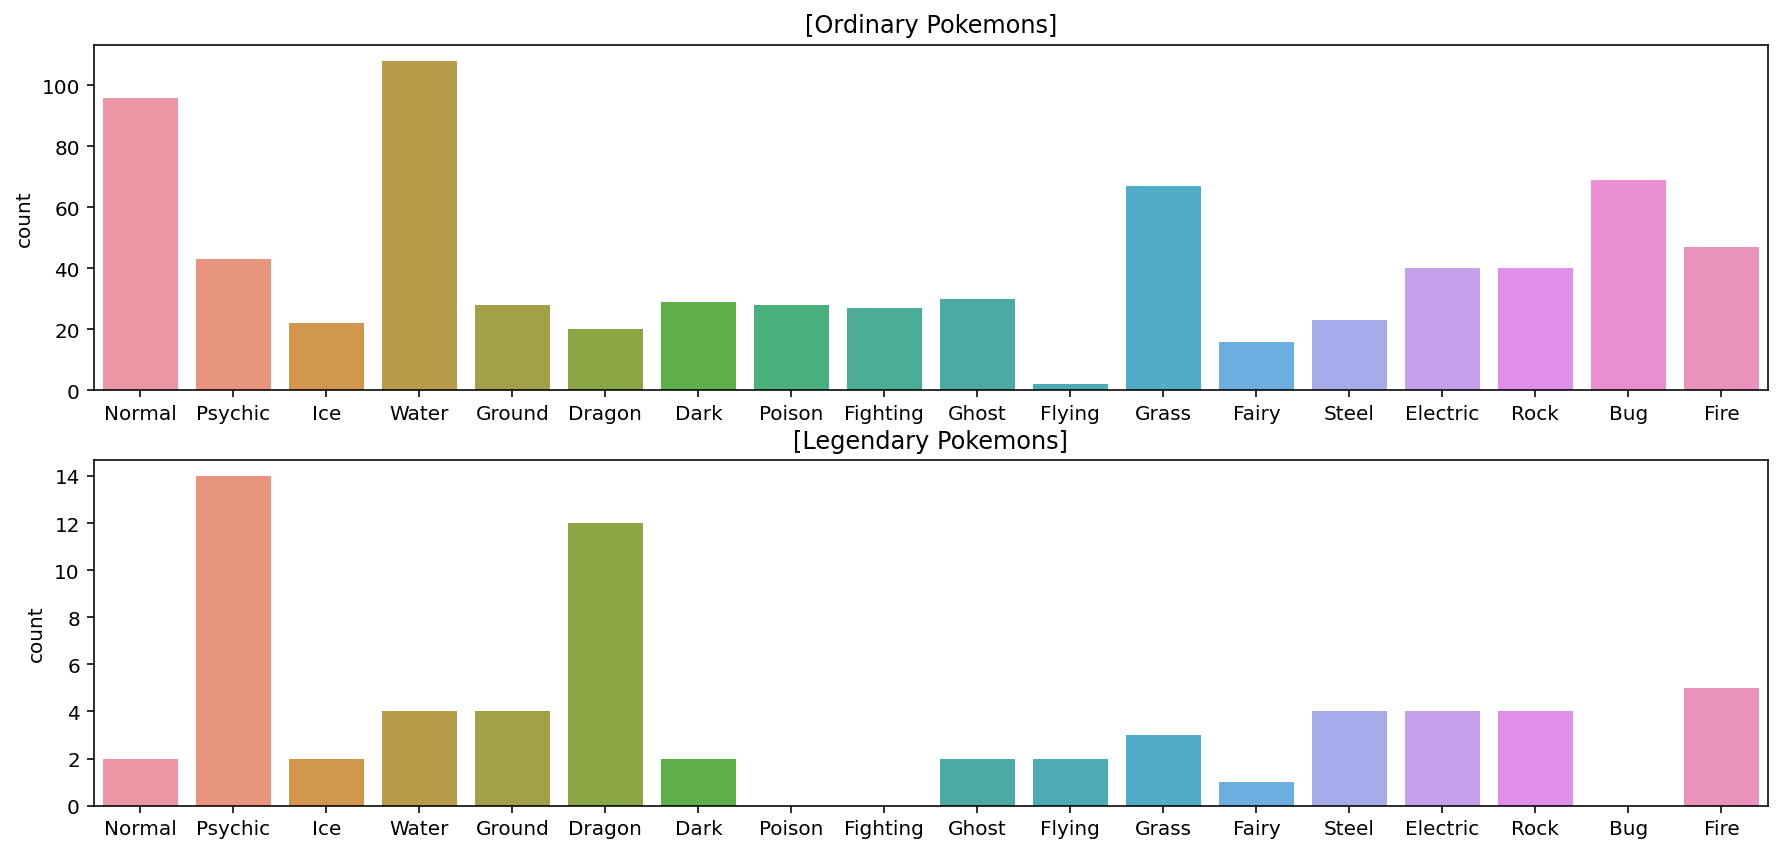

In [175]:
plt.figure(figsize=(15, 7))  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=ordinary, x="Type 1", order=types).set_xlabel('')
plt.title("[Ordinary Pokemons]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 1", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()

In [176]:
pd.pivot_table(pokemon, index="Type 1", values="Legendary").sort_values(by=["Legendary"], ascending=False)

,Legendary
Type 1,
Flying,0.500000
Dragon,0.375000
Psychic,0.245614
Steel,0.148148
Ground,0.125000
Fire,0.096154
Electric,0.090909
Rock,0.090909
Ice,0.083333


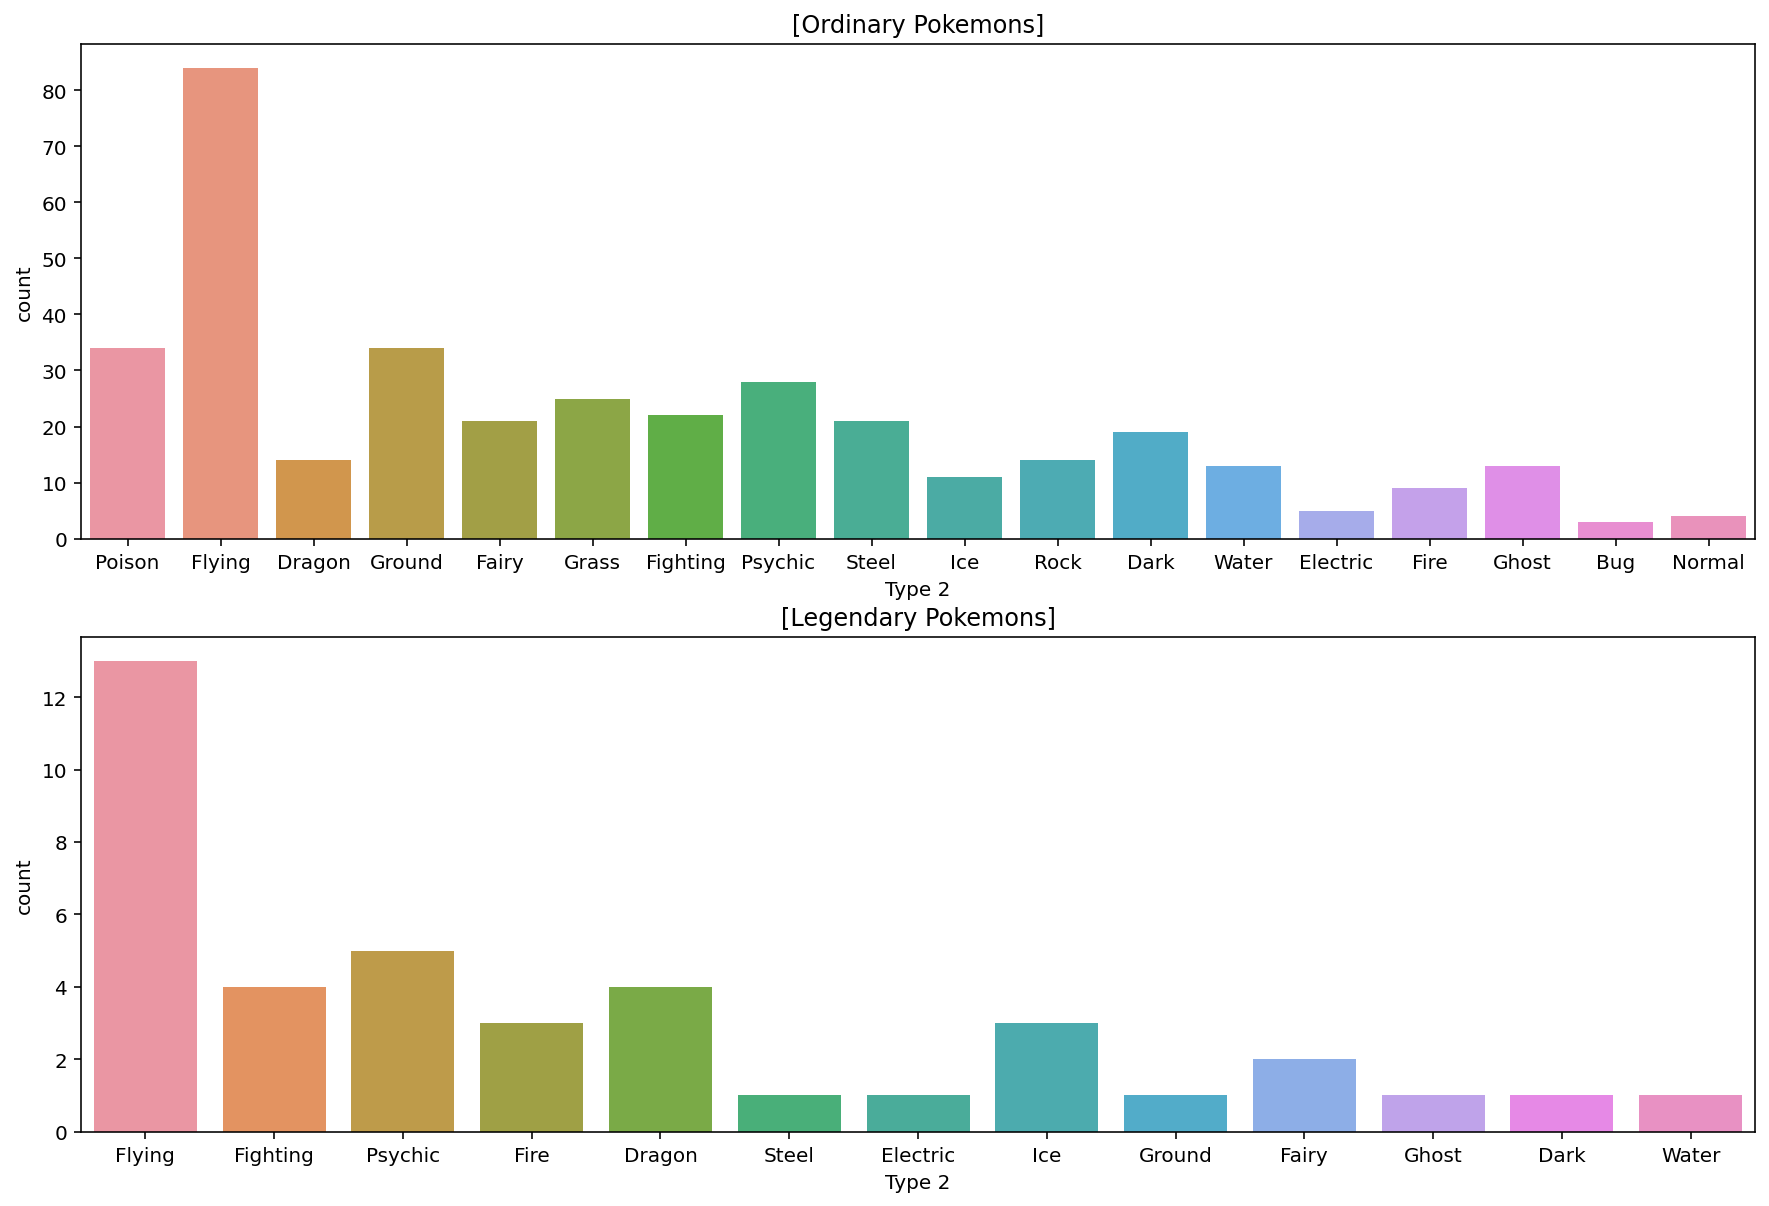

In [177]:
# Q. 아래 코드의 빈칸을 채워주세요.
plt.figure(figsize=(15, 10))  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=ordinary, x="Type 2")
plt.title("[Ordinary Pokemons]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 2")
plt.title("[Legendary Pokemons]")

plt.show()

In [178]:
pd.pivot_table(pokemon, index="Type 2", values="Legendary").sort_values(by=["Legendary"], ascending=False)

,Legendary
Type 2,
Fire,0.250000
Dragon,0.222222
Ice,0.214286
Electric,0.166667
Fighting,0.153846
Psychic,0.151515
Flying,0.134021
Fairy,0.086957
Water,0.071429


* __능력치 정리__

In [179]:
stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
stats

['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

* 모든 stats합산 시, total의 값이 나온다.

In [180]:
print("#0 pokemon: ", pokemon.loc[0, "Name"])
print("total: ", int(pokemon.loc[0, "Total"]))
print("stats: ", list(pokemon.loc[0, stats]))
print("sum of all stats: ", sum(list(pokemon.loc[0, stats])))

#0 pokemon:  Bulbasaur
total:  318
stats:  [45, 49, 49, 65, 65, 45]
sum of all stats:  318


* 조건 절로 주어지더라도 800줄 모두 나오는 것을 확인할 수 있다

In [181]:
# Q. 'pokemon['Total'].values'와 'pokemon[stats].values의 총합'이 같은 포켓몬의 수를 확인해봅시다.
cond = pokemon['Total'] == pokemon[stats].sum(axis=1)
pokemon[cond]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


* __타입별 토탈 수치 시각화 : 전설 포켓몬이 상위에 위치한 것을 확인할 수 있다.__

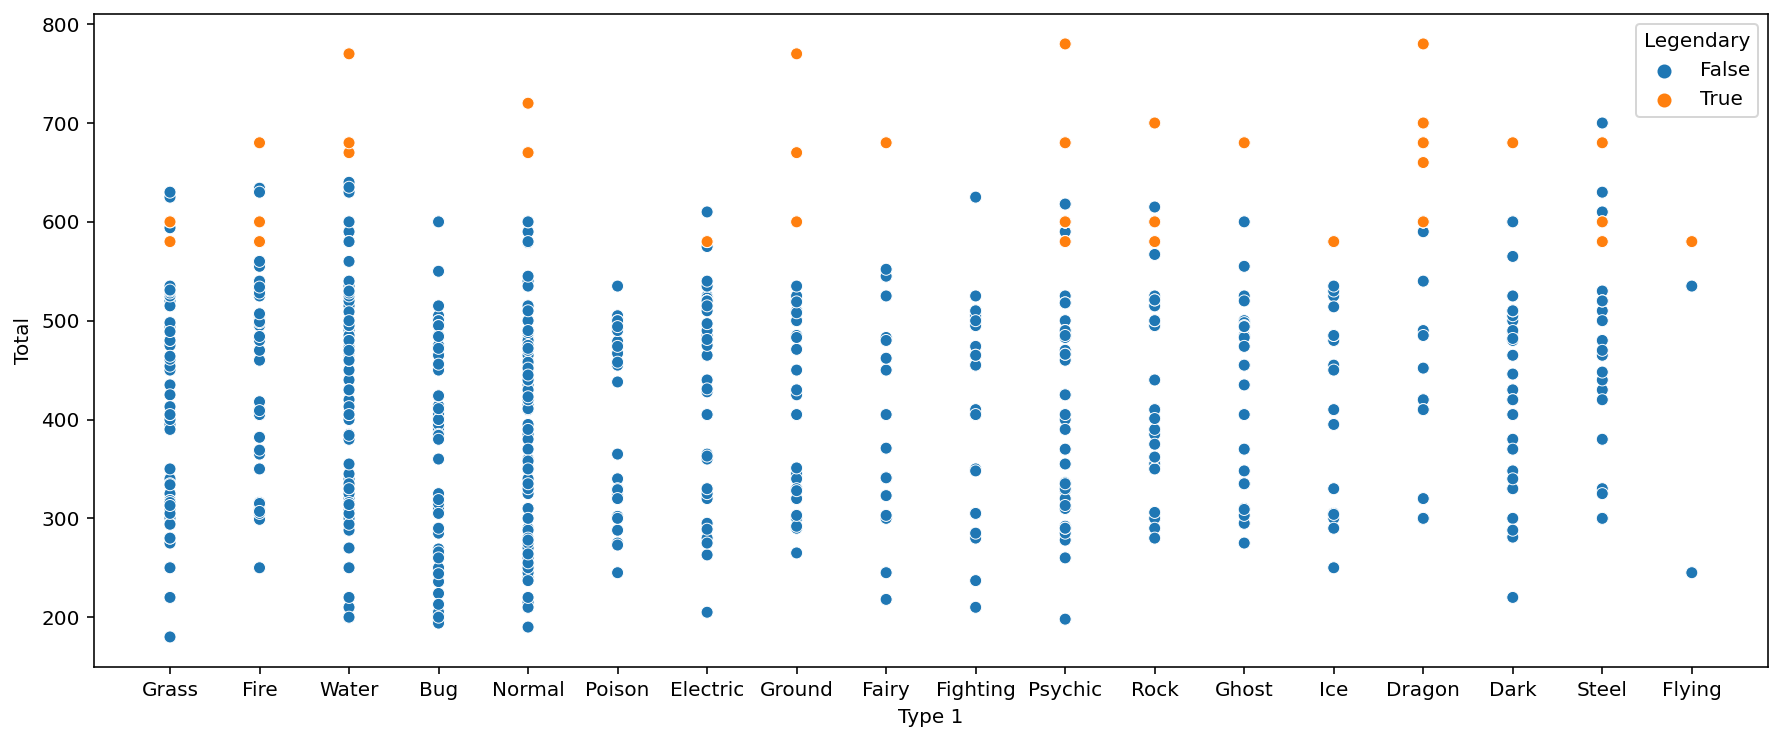

In [182]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

sns.scatterplot(data=pokemon, x="Type 1", y="Total", hue="Legendary")
plt.show()

* __각 stats별 산점도__

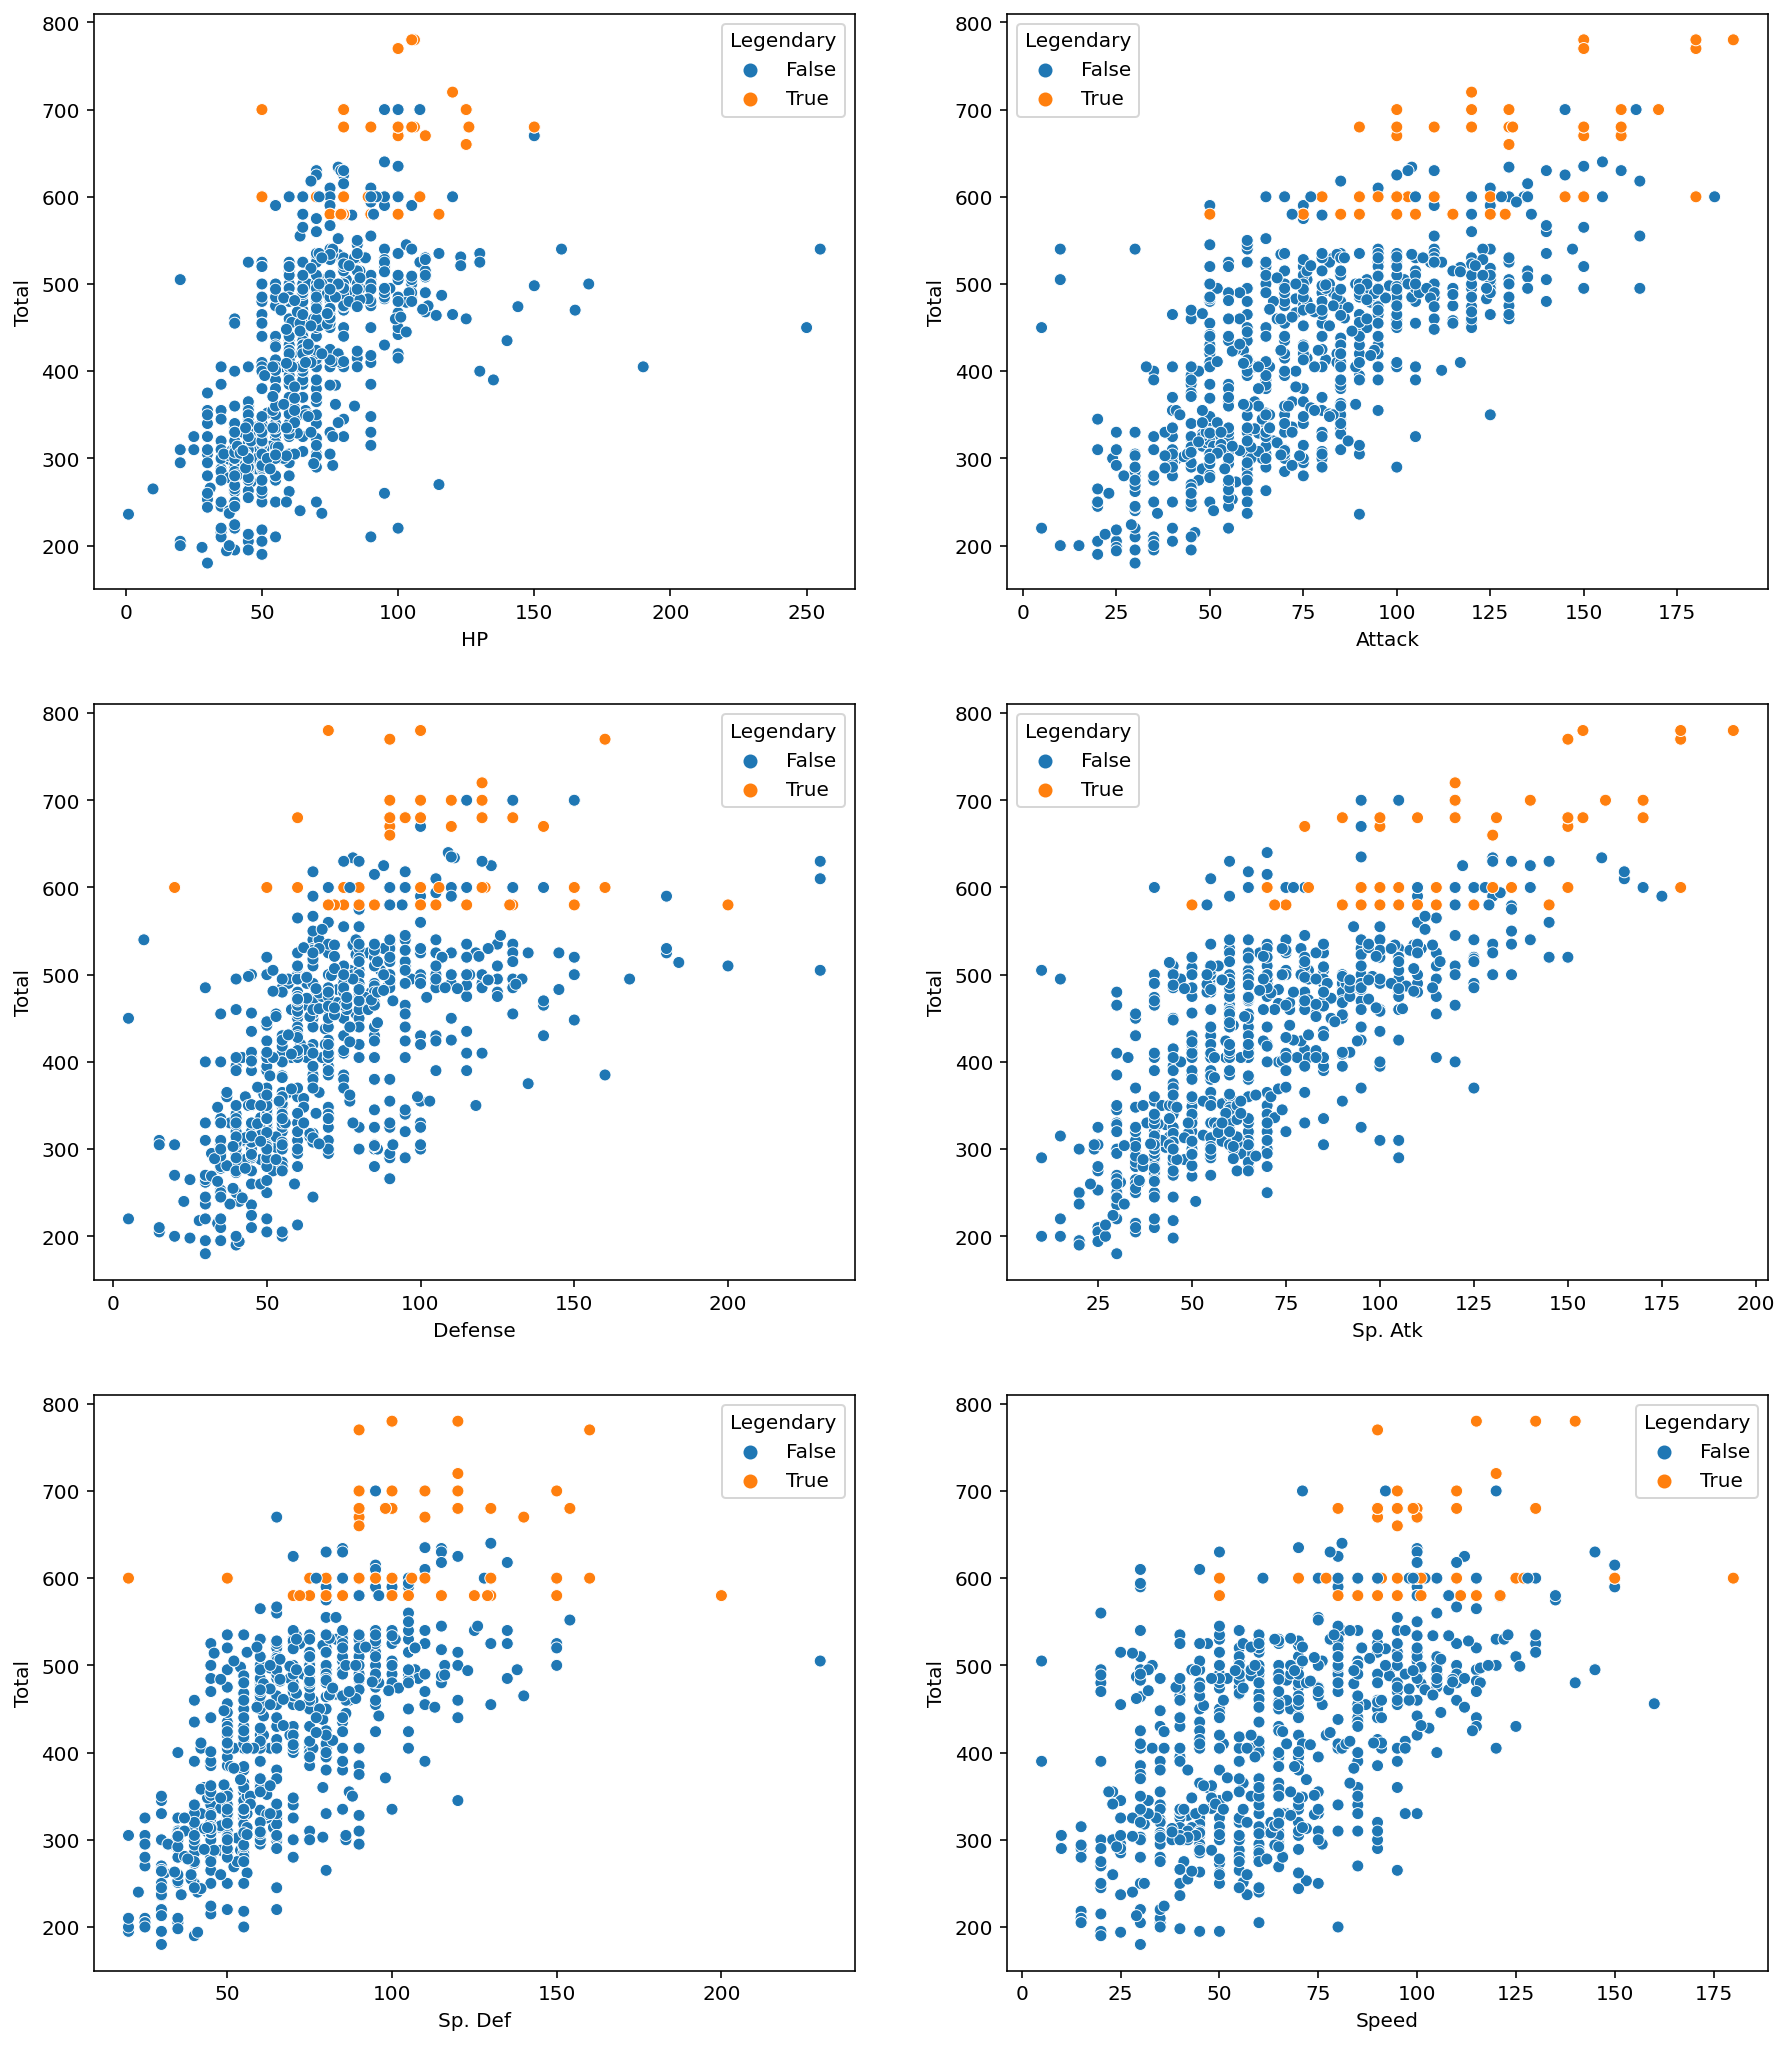

In [183]:
# Q. 다음 코드의 빈칸을 채워주세요.
# 각각의 스탯에 대한 scatter plot을 6개의 subplot으로 표현합니다.

figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(15, 18)  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

# "HP" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="HP", hue="Legendary", ax=ax1)

# "Attack" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Attack", hue="Legendary", ax=ax2)

# "Defense" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Defense", hue="Legendary", ax=ax3)

# "Sp. Atk" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Atk", hue="Legendary", ax=ax4)

# "Sp. Def" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Def", hue="Legendary", ax=ax5)

# "Speed" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Speed", hue="Legendary", ax=ax6)

plt.show()

* 세대가 증가할 수록 일반 포켓몬과 전설 포켓몬의 숫자는 비슷해진다(데이터 기준)

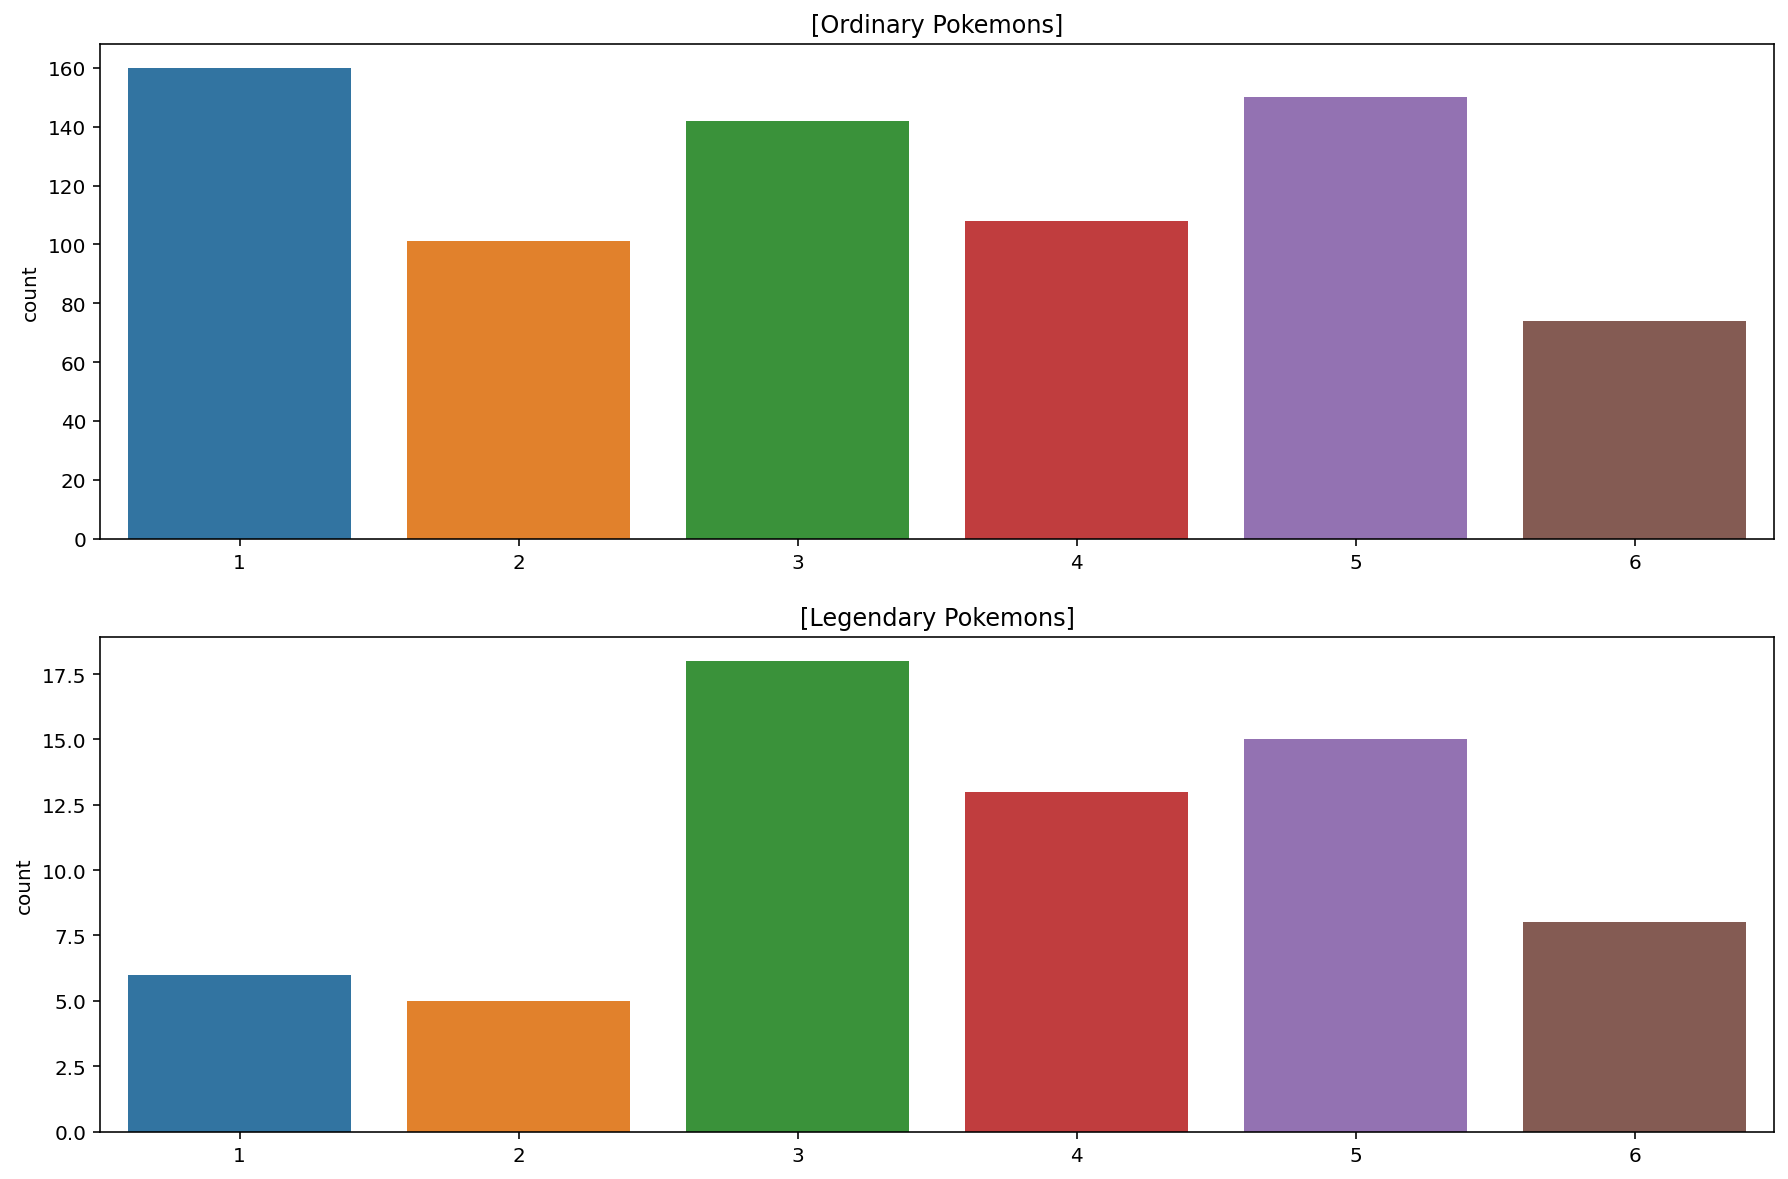

In [184]:
plt.figure(figsize=(15, 10))   # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=ordinary, x="Generation").set_xlabel('')
plt.title("[Ordinary Pokemons]")
plt.subplot(212)
sns.countplot(data=legendary, x="Generation").set_xlabel('')
plt.title("[Legendary Pokemons]")
plt.show()

* 전설 포켓몬의 경우 토탈 값이 같은 점수에 많이 분포되어 있어, 중복제거 시 9가지 값만 나온다는 것을 알 수 있다

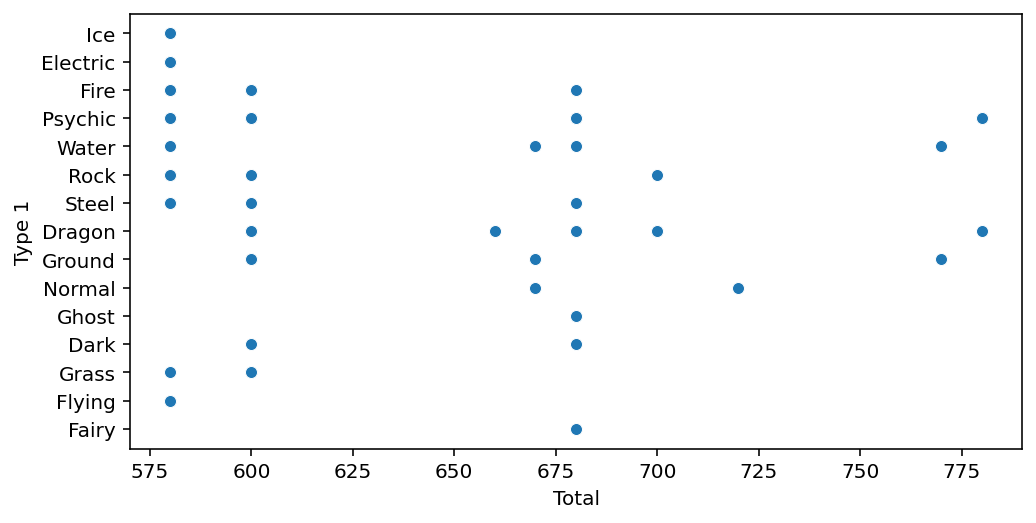

In [185]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

sns.scatterplot(data=legendary, y="Type 1", x="Total")
plt.show()

In [186]:
print(sorted(list(set(legendary["Total"]))))

[580, 600, 660, 670, 680, 700, 720, 770, 780]


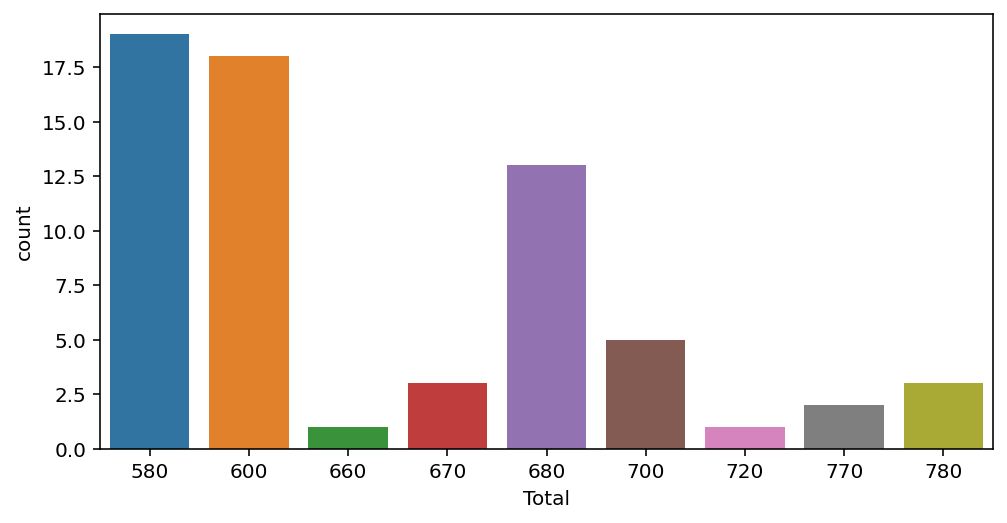

In [187]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

sns.countplot(data=legendary, x="Total")
plt.show()

* 평균적으로 전설포켓몬은 7.22마리씩 같은 수치의 능력을 지닌다.

In [188]:
round(65 / 9, 2)

7.22

* __일반 포켓몬 능력 조회__

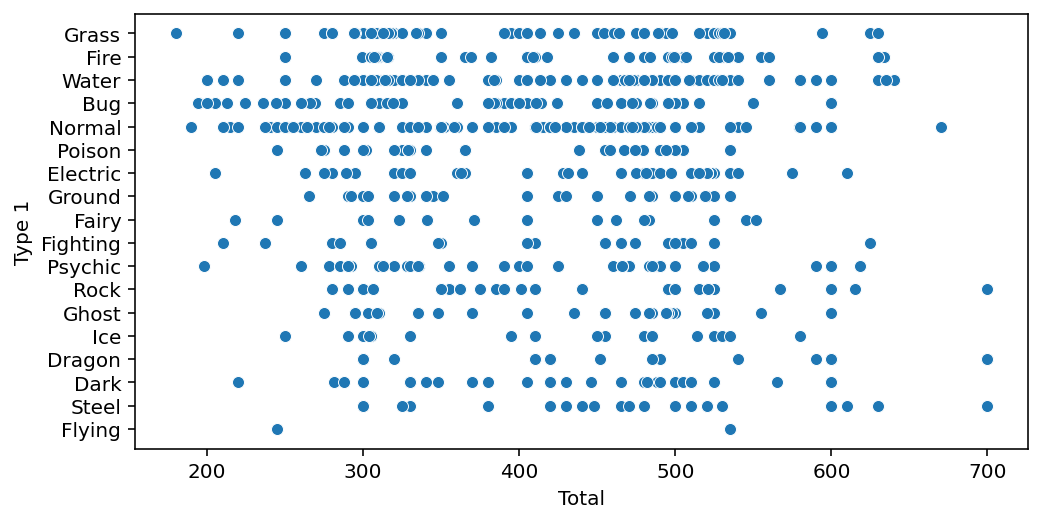

In [189]:
# Q. ordinary 포켓몬의 'Total' 값 집합을 확인해봅시다.
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

sns.scatterplot(data=ordinary, y="Type 1", x="Total")
plt.show()

In [190]:
len(set(ordinary["Total"]))

195

* __이름의 특징 조회__

In [191]:
n1, n2, n3, n4, n5 = legendary[3:6], legendary[14:24], legendary[25:29], legendary[46:50], legendary[52:57]
names = pd.concat([n1, n2, n3, n4, n5]).reset_index(drop=True)
names

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
1,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True
2,150,MewtwoMega Mewtwo Y,Psychic,NaN,780,106,150,70,194,120,140,1,True
3,380,Latias,Dragon,Psychic,600,80,80,90,110,130,110,3,True
4,380,LatiasMega Latias,Dragon,Psychic,700,80,100,120,140,150,110,3,True
5,381,Latios,Dragon,Psychic,600,80,90,80,130,110,110,3,True
6,381,LatiosMega Latios,Dragon,Psychic,700,80,130,100,160,120,110,3,True
7,382,Kyogre,Water,NaN,670,100,100,90,150,140,90,3,True
8,382,KyogrePrimal Kyogre,Water,NaN,770,100,150,90,180,160,90,3,True
9,383,Groudon,Ground,NaN,670,100,150,140,100,90,90,3,True


In [192]:
formes = names[13:23]
formes

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
13,386,DeoxysNormal Forme,Psychic,NaN,600,50,150,50,150,50,150,3,True
14,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True
15,386,DeoxysDefense Forme,Psychic,NaN,600,50,70,160,70,160,90,3,True
16,386,DeoxysSpeed Forme,Psychic,NaN,600,50,95,90,95,90,180,3,True
17,641,TornadusIncarnate Forme,Flying,NaN,580,79,115,70,125,80,111,5,True
18,641,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,True
19,642,ThundurusIncarnate Forme,Electric,Flying,580,79,115,70,125,80,111,5,True
20,642,ThundurusTherian Forme,Electric,Flying,580,79,105,70,145,80,101,5,True
21,645,LandorusIncarnate Forme,Ground,Flying,600,89,125,90,115,80,101,5,True
22,645,LandorusTherian Forme,Ground,Flying,600,89,145,90,105,80,91,5,True


* __이름의 글자 수 빈도 체크__

In [193]:
legendary["name_count"] = legendary["Name"].apply(lambda i: len(i))    
legendary.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True,8
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True,6
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True,7
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,6
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True,19


In [239]:
# Q. ordinary 포켓몬의 데이터에도 'name_count' 값을 추가해줍시다.
ordinary["name_count"] = ordinary["Name"].apply(lambda x : len(x))
ordinary.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


* __이름의 글자 수별 빈도 시각화 : 전설의 포켓몬은 16글자 이상이 많지만, 일반 포켓몬은 거의 없다__

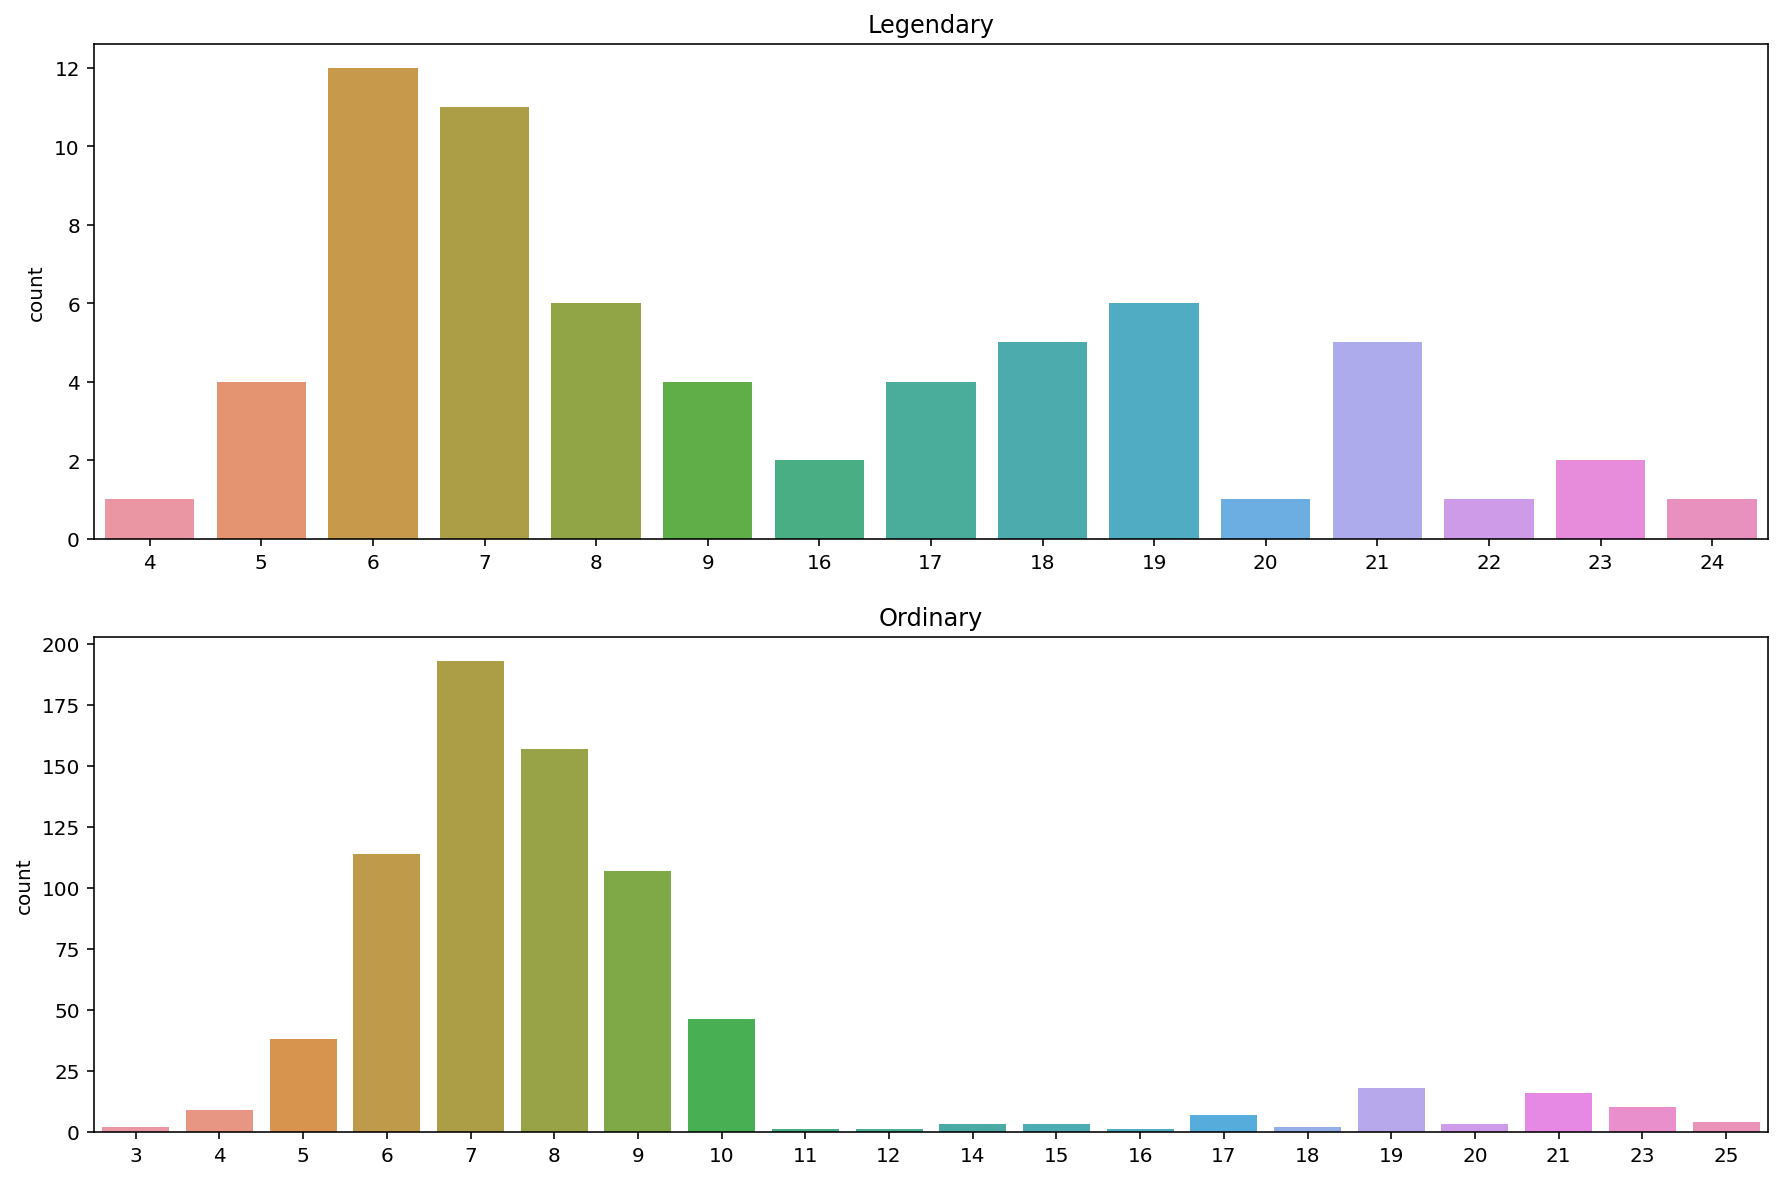

In [195]:
plt.figure(figsize=(15, 10))   # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=legendary, x="name_count").set_xlabel('')
plt.title("Legendary")
plt.subplot(212)
sns.countplot(data=ordinary, x="name_count").set_xlabel('')
plt.title("Ordinary")
plt.show()

* 비율로 비교

In [196]:
print(round(len(legendary[legendary["name_count"] > 9]) / len(legendary) * 100, 2), "%")

41.54 %


* long_name과 name_isalpha 파생 파라미터 생성

In [197]:
pokemon["name_count"] = pokemon["Name"].apply(lambda i: len(i))
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


In [198]:
pokemon["long_name"] = pokemon["name_count"] >= 10
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True


In [199]:
pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,7,False,Diancie
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,19,True,DiancieMegaDiancie
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,19,True,HoopaHoopaConfined
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,18,True,HoopaHoopaUnbound
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True,9,False,Volcanion


In [200]:
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False,Bulbasaur,True
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False,Ivysaur,True
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False,Venusaur,True
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True,VenusaurMegaVenusaur,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True,Charmander,True


In [201]:
print(pokemon[pokemon["name_isalpha"] == False].shape)
pokemon[pokemon["name_isalpha"] == False]

(9, 17)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran♀,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran♀,False
37,32,Nidoran♂,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran♂,False
90,83,Farfetch'd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetch'd,False
131,122,Mr. Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon2,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon2,False
270,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho-oh,False
487,439,Mime Jr.,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon-Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon-Z,False
794,718,Zygarde50% Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


* 이름에서 특수문자 제거

In [202]:
pokemon = pokemon.replace(to_replace="Nidoran♀", value="Nidoran X")
pokemon = pokemon.replace(to_replace="Nidoran♂", value="Nidoran Y")
pokemon = pokemon.replace(to_replace="Farfetch'd", value="Farfetchd")
pokemon = pokemon.replace(to_replace="Mr. Mime", value="Mr Mime")
pokemon = pokemon.replace(to_replace="Porygon2", value="Porygon Two")
pokemon = pokemon.replace(to_replace="Ho-oh", value="Ho Oh")
pokemon = pokemon.replace(to_replace="Mime Jr.", value="Mime Jr")
pokemon = pokemon.replace(to_replace="Porygon-Z", value="Porygon Z")
pokemon = pokemon.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

pokemon.loc[[34, 37, 90, 131, 252, 270, 487, 525, 794]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran X,False
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran Y,False
90,83,Farfetchd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetchd,False
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon Two,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon Two,False
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho Oh,False
487,439,Mime Jr,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon Z,False
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


In [203]:
# Q. 바꿔준 'Name' 컬럼으로 'Name_nospace'를 만들고, 다시 isalpha()로 체크해봅시다.
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda x: x.isalpha())
pokemon[pokemon["name_isalpha"] == False]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran X,False
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran Y,False
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon Two,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon Two,False
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho Oh,False
487,439,Mime Jr,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon Z,False
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


* __정규식 활용__

In [204]:
import re
name = "CharizardMega Charizard X"
name_split = name.split(" ")
name_split

['CharizardMega', 'Charizard', 'X']

In [205]:
temp = name_split[0]
temp

'CharizardMega'

In [206]:
tokens = re.findall('[A-Z][a-z]*', temp)
tokens

['Charizard', 'Mega']

In [207]:
tokens = []
for part_name in name_split:
    a = re.findall('[A-Z][a-z]*', part_name)
    tokens.extend(a)
tokens

['Charizard', 'Mega', 'Charizard', 'X']

* __tokenize함수 생성__

In [208]:
# Q. 다음 코드의 빈칸을 채워주세요.
def tokenize(name):
    tokens = []
    name_split = name.split(" ")
    for part_name in name_split:
        a = re.findall('[A-Z][a-z]*', part_name)
        tokens.extend(a)
    return np.array(tokens)

In [209]:
name = "CharizardMega Charizard X"
tokenize(name)

array(['Charizard', 'Mega', 'Charizard', 'X'], dtype='<U9')

* 중복 제거시 65개의 토큰 생성됨을 확인

In [210]:
tokens = []
all_tokens = list(legendary["Name"].apply(tokenize).values)

token_set = []
for token in all_tokens:
    token_set.extend(token)

print(len(set(token_set)))
print(token_set)

65
['Articuno', 'Zapdos', 'Moltres', 'Mewtwo', 'Mewtwo', 'Mega', 'Mewtwo', 'X', 'Mewtwo', 'Mega', 'Mewtwo', 'Y', 'Raikou', 'Entei', 'Suicune', 'Lugia', 'Ho', 'Regirock', 'Regice', 'Registeel', 'Latias', 'Latias', 'Mega', 'Latias', 'Latios', 'Latios', 'Mega', 'Latios', 'Kyogre', 'Kyogre', 'Primal', 'Kyogre', 'Groudon', 'Groudon', 'Primal', 'Groudon', 'Rayquaza', 'Rayquaza', 'Mega', 'Rayquaza', 'Jirachi', 'Deoxys', 'Normal', 'Forme', 'Deoxys', 'Attack', 'Forme', 'Deoxys', 'Defense', 'Forme', 'Deoxys', 'Speed', 'Forme', 'Uxie', 'Mesprit', 'Azelf', 'Dialga', 'Palkia', 'Heatran', 'Regigigas', 'Giratina', 'Altered', 'Forme', 'Giratina', 'Origin', 'Forme', 'Darkrai', 'Shaymin', 'Land', 'Forme', 'Shaymin', 'Sky', 'Forme', 'Arceus', 'Victini', 'Cobalion', 'Terrakion', 'Virizion', 'Tornadus', 'Incarnate', 'Forme', 'Tornadus', 'Therian', 'Forme', 'Thundurus', 'Incarnate', 'Forme', 'Thundurus', 'Therian', 'Forme', 'Reshiram', 'Zekrom', 'Landorus', 'Incarnate', 'Forme', 'Landorus', 'Therian', 'Form

In [211]:
from collections import Counter
a = [1, 1, 0, 0, 0, 1, 1, 2, 3]
Counter(a)

Counter({1: 4, 0: 3, 2: 1, 3: 1})

In [212]:
Counter(a).most_common()

[(1, 4), (0, 3), (2, 1), (3, 1)]

* counter를 활용하여 Forme가 전설 포켓몬의 최빈 토큰임을 확인

In [213]:
most_common = Counter(token_set).most_common(10)
most_common

[('Forme', 15),
 ('Mega', 6),
 ('Mewtwo', 5),
 ('Kyurem', 5),
 ('Deoxys', 4),
 ('Hoopa', 4),
 ('Latias', 3),
 ('Latios', 3),
 ('Kyogre', 3),
 ('Groudon', 3)]

* __이름으로 생성된 토큰으로 원핫인코딩__

In [214]:
for token, _ in most_common:
    # pokemon[token] = ... 형식으로 사용하면 뒤에서 warning이 발생합니다
    pokemon[f"{token}"] = pokemon["Name"].str.contains(token)

pokemon.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,...,Forme,Mega,Mewtwo,Kyurem,Deoxys,Hoopa,Latias,Latios,Kyogre,Groudon
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,False,False,False,False,False,False,False,False,False,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,False,False,False,False,False,False,False,False,False,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,False,False,False,False,False,False,False,False,False,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,...,False,True,False,False,False,False,False,False,False,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,False,False,False,False,False,False,False,False,False,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,False,False,False,False,False,False,False,False,False,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,...,False,False,False,False,False,False,False,False,False,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,...,False,True,False,False,False,False,False,False,False,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,...,False,True,False,False,False,False,False,False,False,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,...,False,False,False,False,False,False,False,False,False,False


* __타입 원핫인코딩__

In [215]:
for t in types:
    pokemon[t] = (pokemon["Type 1"] == t) | (pokemon["Type 2"] == t)
    
pokemon[[["Type 1", "Type 2"] + types][0]].head()

,Type 1,Type 2,Normal,Psychic,Ice,Water,Ground,Dragon,Dark,Poison,Fighting,Ghost,Flying,Grass,Fairy,Steel,Electric,Rock,Bug,Fire
0,Grass,Poison,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
1,Grass,Poison,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
2,Grass,Poison,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
3,Grass,Poison,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
4,Fire,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [216]:
print(original_data.shape)
original_data.head()

(800, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [217]:
original_data.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

* __학습 모델 생성__

In [218]:
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']

In [219]:
target = 'Legendary'

In [220]:
# Q. 'original_data'에서 'features' 컬럼에 해당하는 데이터를 변수 'X'에 저장합니다.
X = original_data[features].copy()
print(X.shape)
X.head()

(800, 8)


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,318,45,49,49,65,65,45,1
1,405,60,62,63,80,80,60,1
2,525,80,82,83,100,100,80,1
3,625,80,100,123,122,120,80,1
4,309,39,52,43,60,50,65,1


In [221]:
# Q. 'target' 컬럼의 데이터를 변수 'y'에 저장합니다.
y = original_data[target].copy()
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

In [222]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 8) (640,)
(160, 8) (160,)


## 머신러닝 모델 만들기
---

In [223]:
from sklearn.tree import DecisionTreeClassifier
print('슝=3')

슝=3


In [224]:
model = DecisionTreeClassifier(random_state=25)
model

DecisionTreeClassifier(random_state=25)

In [225]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('슝=3')

슝=3


TN FN

---

FP TP

In [226]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[144,   3],
       [  5,   8]])

In [227]:
len(legendary)

65

* 데이터가 불균형하기에 정확성은 의미없는 수치이다(대부분을 일반몬스터라 판단해도 정확도가 그리 떨어지지 않는다).
* __여기선 전설 포켓몬의 재현율 recall의 수치를 올리는 것이 중요하다__

In [228]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



In [229]:
print(len(pokemon.columns))
print(pokemon.columns)

45
Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'name_count',
       'long_name', 'Name_nospace', 'name_isalpha', 'Forme', 'Mega', 'Mewtwo',
       'Kyurem', 'Deoxys', 'Hoopa', 'Latias', 'Latios', 'Kyogre', 'Groudon',
       'Normal', 'Psychic', 'Ice', 'Water', 'Ground', 'Dragon', 'Dark',
       'Poison', 'Fighting', 'Ghost', 'Flying', 'Grass', 'Fairy', 'Steel',
       'Electric', 'Rock', 'Bug', 'Fire'],
      dtype='object')


* __이번엔 능력치들 뿐만이 아닌, 토큰과 특성 또한 같이 활용해보겠다__
    * __이때 #, Name, Type 1, Type 2 등 필요 없거나 레이블 데이터를 빼고 작성해야한다.__

In [230]:
features = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 
            'name_count','long_name', 'Forme', 'Mega', 'Mewtwo','Deoxys', 'Kyurem', 'Latias', 'Latios',
            'Kyogre', 'Groudon', 'Hoopa','Poison', 'Ground', 'Flying', 'Normal', 'Water', 'Fire',
            'Electric','Rock', 'Dark', 'Fairy', 'Steel', 'Ghost', 'Psychic', 'Ice', 'Bug', 'Grass', 'Dragon', 'Fighting']

len(features)

38

In [231]:
target = "Legendary"
target

'Legendary'

In [232]:
# Q. 사용할 feature에 해당하는 데이터를 'X' 변수에 저장합니다.
X = pokemon[features]
print(X.shape)
X.head()

(800, 38)


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,name_count,long_name,...,Dark,Fairy,Steel,Ghost,Psychic,Ice,Bug,Grass,Dragon,Fighting
0,318,45,49,49,65,65,45,1,9,False,...,False,False,False,False,False,False,False,True,False,False
1,405,60,62,63,80,80,60,1,7,False,...,False,False,False,False,False,False,False,True,False,False
2,525,80,82,83,100,100,80,1,8,False,...,False,False,False,False,False,False,False,True,False,False
3,625,80,100,123,122,120,80,1,21,True,...,False,False,False,False,False,False,False,True,False,False
4,309,39,52,43,60,50,65,1,10,True,...,False,False,False,False,False,False,False,False,False,False


In [233]:
# Q. 정답 데이터 'y'도 'target' 변수를 이용해 만들어줍시다.
y = pokemon[target]
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 38) (640,)
(160, 38) (160,)


In [235]:
model = DecisionTreeClassifier(random_state=25)
model

DecisionTreeClassifier(random_state=25)

In [236]:
# Q. train 데이터로 decision tree 모델을 학습시키고
# test 데이터로 모델의 예측 값을 얻어봅시다!
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [237]:
# Q. classification report도 확인해봅시다!
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160



* __변수들을 증가시킨 결과, 재현율 전설의 포켓몬 recall값이 0.92로 크게 상승한 것을 확인할 수 있다.__

## 회고
---


 - [x] __전반적인 코드 이해하는 데 어려움은 없었나? 없었다면 체크__
 - [x] __EDA과정에서 이해되지 않던 부분은 없었나? 없었다면 체크__
 - [x] __왜 데이터 불균형이 문제가 되는지 이해하였나? 이해하였다면 체크__
 - [x] __여기서 왜 재현율이 중요하였는 지 이해하였나? 이해하였다면 체크__

* 1번 : pandas, sklearn이라는 일련의 과정들을 배웠기에 이해하는데 크게 어려움은 없었다.

* 2번 : seaborn을 통해 시각화를 하면서 데이터의 의미를 파악하는 부분이 좋았다. 차 후 정규성 검정 등 통계학적 지식을 활용해서 하는 법 또한 궁금하다.

* 3번 : 말그대로 여러 수치들을 부풀리는 경향이 있을 수 있다는 것을 깨달았다. 왜 굳이 균일한 데이터 셋을 갖추기 위해 노력하는 지 깨달을 수 있었다.

* 4번 : 데이터 셋이 전설의 포켓몬의 비율이 적고, 대부분이 일반 포켓몬에 속하기 때문에, 얼만큼 전설의 포켓몬을 잘 찾아내는 지가 중요했던 것 같다. 